In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize_scalar, minimize
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
warnings.filterwarnings('ignore')

Part-I: Reproduction

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# DATA LOADING AND PREPARATION
print("="*80)
print("DYNAMIC RETAIL PRICING VIA Q-LEARNING")
print("Reproducing Results from arXiv:2411.18261")
print("="*80)

# Load dataset
Path = "DatafinitiElectronicsProductsPricingData.csv"
df = pd.read_csv(Path)

print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {len(df):,}")

# Select relevant columns
relevant_columns = [
    'name', 'brand', 'manufacturer', 
    'prices.amountMax', 'prices.amountMin', 
    'prices.availability', 'prices.condition',
    'prices.merchant', 'prices.dateSeen',
    'primaryCategories', 'categories'
]

df_clean = df[relevant_columns].copy()
df_clean.columns = [
    'name', 'brand', 'manufacturer',
    'price_max', 'price_min',
    'availability', 'condition',
    'merchant', 'date_seen',
    'primary_category', 'categories'
]

# Data cleaning
df_clean['price_max'] = pd.to_numeric(df_clean['price_max'], errors='coerce')
df_clean['price_min'] = pd.to_numeric(df_clean['price_min'], errors='coerce')
df_clean = df_clean.dropna(subset=['price_max', 'price_min'])
df_clean['condition'] = df_clean['condition'].str.lower().str.strip()
df_clean = df_clean[df_clean['condition'] == 'new']
df_clean = df_clean[(df_clean['price_max'] > 0) & (df_clean['price_max'] < 10000)]
df_clean = df_clean[(df_clean['price_min'] > 0) & (df_clean['price_min'] < 10000)]

print(f"After cleaning: {df_clean.shape[0]:,} rows")


# TV PRODUCT EXTRACTION (As per paper)

tv_keywords = ['tv', 'television', 'hdtv', '4k', 'led', 'lcd', 'smart tv', 'uhd', 'fhd', 'hd']

def contains_tv_keyword(text):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in tv_keywords)

df_tv = df_clean[
    df_clean['name'].apply(contains_tv_keyword) | 
    df_clean['categories'].apply(contains_tv_keyword)
].copy()

print(f"\nTV-related products: {df_tv.shape[0]:,} rows")
print(f"Unique TV products: {df_tv['name'].nunique():,}")


# PRODUCT STATISTICS CALCULATION
product_stats = df_tv.groupby('name').agg({
    'price_max': ['mean', 'std', 'min', 'max', 'count'],
    'price_min': ['mean', 'std'],
    'brand': 'first',
    'merchant': 'nunique'
}).reset_index()

product_stats.columns = [
    'name', 
    'base_price', 'price_std', 'price_min', 'price_max', 'observation_count',
    'avg_min_price', 'min_price_std',
    'brand', 'merchant_count'
]

DYNAMIC RETAIL PRICING VIA Q-LEARNING
Reproducing Results from arXiv:2411.18261

Dataset Shape: (14592, 31)
Total Records: 14,592
After cleaning: 12,247 rows

TV-related products: 5,628 rows
Unique TV products: 515


In [13]:
# Calculate base demand (higher observations = higher demand)
max_obs = product_stats['observation_count'].max()
min_obs = product_stats['observation_count'].min()
product_stats['base_demand'] = 40 + (product_stats['observation_count'] - min_obs) / (max_obs - min_obs + 1) * 260
product_stats['base_demand'] = product_stats['base_demand'].round().astype(int)

# SELECT PRODUCTS TO MATCH PAPER TESTING (14 PRODUCTS)
paper_products = {
    'Samsung 24" HD': {'price': 109.2, 'demand': 80, 'elasticity': -0.5},
    'Samsung 55" 4K': {'price': 674.3, 'demand': 54, 'elasticity': -1.7},
    'Hisense 65" 4K': {'price': 1412.1, 'demand': 49, 'elasticity': -1.1},
    'Samsung 40" FHD': {'price': 260.5, 'demand': 67, 'elasticity': -0.7},
    'Samsung 49" 4K MU6290': {'price': 444.7, 'demand': 57, 'elasticity': -0.3},
    'Samsung 49" 4K Q6F': {'price': 829.0, 'demand': 97, 'elasticity': -4.4},
    'Samsung 50" FHD': {'price': 418.4, 'demand': 56, 'elasticity': -0.8},
    'Samsung 55" 4K Q8F': {'price': 2011.6, 'demand': 60, 'elasticity': -8.4},
    'Samsung 65" 4K Q7F': {'price': 2411.6, 'demand': 60, 'elasticity': -7.8},
    'Samsung 24" HD UN24H4500': {'price': 142.7, 'demand': 40, 'elasticity': -1.9},
    'Sony 40" FHD': {'price': 423.8, 'demand': 27, 'elasticity': -0.8},
    'Sony 43" 4K UHD': {'price': 648.0, 'demand': 154, 'elasticity': -5.6},
    'VIZIO 39" FHD': {'price': 249.8, 'demand': 59, 'elasticity': -1.8},
    'VIZIO 70" 4K XHDR': {'price': 1300.0, 'demand': 36, 'elasticity': -6.5}
}

selected_products = pd.DataFrame([
    {
        'name': name,
        'brand': name.split()[0],
        'base_price': data['price'],
        'base_demand': data['demand'],
        'elasticity': data['elasticity'],
        'cost': data['price'] * 0.5
    }
    for name, data in paper_products.items()
])

print("\n" + "="*80)
print("TABLE I: BASE PRICES, BASE DEMAND, AND PRICE ELASTICITY (From Paper)")
print("="*80)
table1 = selected_products[['name', 'base_price', 'base_demand', 'elasticity']].copy()
table1.columns = ['Product Name', 'Price', 'Demand', 'Price Elasticity']
print(table1.to_string(index=False))

# DEMAND AND REVENUE FUNCTIONS (Equation 1 from paper)
def calculate_demand(price, base_price, base_demand, elasticity):
    price_change_ratio = (price - base_price) / base_price
    demand = base_demand + (base_demand * elasticity * price_change_ratio)
    return max(0, demand)

def calculate_revenue(price, base_price, base_demand, elasticity):
    demand = calculate_demand(price, base_price, base_demand, elasticity)
    return price * demand

def calculate_profit(price, base_price, base_demand, elasticity, cost):
    demand = calculate_demand(price, base_price, base_demand, elasticity)
    profit = demand * (price - cost)
    return profit


TABLE I: BASE PRICES, BASE DEMAND, AND PRICE ELASTICITY (From Paper)
            Product Name  Price  Demand  Price Elasticity
          Samsung 24" HD  109.2      80              -0.5
          Samsung 55" 4K  674.3      54              -1.7
          Hisense 65" 4K 1412.1      49              -1.1
         Samsung 40" FHD  260.5      67              -0.7
   Samsung 49" 4K MU6290  444.7      57              -0.3
      Samsung 49" 4K Q6F  829.0      97              -4.4
         Samsung 50" FHD  418.4      56              -0.8
      Samsung 55" 4K Q8F 2011.6      60              -8.4
      Samsung 65" 4K Q7F 2411.6      60              -7.8
Samsung 24" HD UN24H4500  142.7      40              -1.9
            Sony 40" FHD  423.8      27              -0.8
         Sony 43" 4K UHD  648.0     154              -5.6
           VIZIO 39" FHD  249.8      59              -1.8
       VIZIO 70" 4K XHDR 1300.0      36              -6.5


In [14]:
# REINFORCEMENT LEARNING ENVIRONMENT
class RetailPricingEnvironment:
    def __init__(self, products_df, n_price_points=20):
        self.products = products_df.reset_index(drop=True)
        self.n_products = len(products_df)
        self.n_price_points = n_price_points
        self.n_day_types = 2
        
        self.price_actions = {}
        for idx, row in self.products.iterrows():
            min_price = row['base_price'] * 0.7
            max_price = row['base_price'] * 1.3
            self.price_actions[idx] = np.linspace(min_price, max_price, n_price_points)
        
        self.n_states = self.n_products * self.n_day_types
        self.n_actions = n_price_points
        
        self.current_product = 0
        self.current_day_type = 0
        
    def get_state_index(self):
        return self.current_product * self.n_day_types + self.current_day_type
    
    def reset(self, product_idx=None, day_type=None):
        if product_idx is None:
            self.current_product = np.random.randint(0, self.n_products)
        else:
            self.current_product = product_idx
            
        if day_type is None:
            self.current_day_type = np.random.randint(0, self.n_day_types)
        else:
            self.current_day_type = day_type
            
        return self.get_state_index()
    
    def step(self, action):
        product = self.products.iloc[self.current_product]
        price = self.price_actions[self.current_product][action]
        
        demand_multiplier = 1.2 if self.current_day_type == 1 else 1.0
        adjusted_base_demand = product['base_demand'] * demand_multiplier
        
        noise = np.random.normal(1.0, 0.05)
        
        demand = calculate_demand(
            price, 
            product['base_price'], 
            adjusted_base_demand, 
            product['elasticity']
        ) * noise
        demand = max(0, demand)
        
        profit = demand * (price - product['cost'])
        
        done = True
        
        info = {
            'price': price,
            'demand': demand,
            'revenue': price * demand,
            'profit': profit
        }
        
        return self.get_state_index(), profit, done, info

# Q-LEARNING AGENT (Equation 2 from paper)
class QLearningAgent:
    def __init__(self, n_states, n_actions, 
                learning_rate=0.1, discount_factor=0.95,
                epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        self.q_table = np.zeros((n_states, n_actions))
        
    def choose_action(self, state_idx, training=True):
        if training and np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            return np.argmax(self.q_table[state_idx])
    
    def update(self, state_idx, action, reward, next_state_idx, done):
        current_q = self.q_table[state_idx, action]
        
        if done:
            target = reward
        else:
            max_next_q = np.max(self.q_table[next_state_idx])
            target = reward + self.gamma * max_next_q
        
        self.q_table[state_idx, action] = (1 - self.alpha) * current_q + self.alpha * target
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [15]:
# TRAINING THE Q-LEARNING AGENT
print("\n" + "="*80)
print("TRAINING Q-LEARNING AGENT")
print("="*80)

env = RetailPricingEnvironment(selected_products, n_price_points=20)

agent = QLearningAgent(
    n_states=env.n_states,
    n_actions=env.n_actions,
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

print(f"Environment: {env.n_products} products, {env.n_states} states, {env.n_actions} actions")
print(f"Agent: α={agent.alpha}, γ={agent.gamma}, ε={agent.epsilon}")

n_episodes = 50000
rewards_history = []
epsilon_history = []

print(f"\nTraining for {n_episodes:,} episodes...")

for episode in tqdm(range(n_episodes), desc="Trainaing"):
    state_idx = env.reset()
    action = agent.choose_action(state_idx, training=True)
    next_state_idx, reward, done, info = env.step(action)
    agent.update(state_idx, action, reward, next_state_idx, done)
    
    rewards_history.append(reward)
    epsilon_history.append(agent.epsilon)
    agent.decay_epsilon()

print(f"\nTraining complete!")
print(f"Final epsilon: {agent.epsilon:.4f}")
print(f"Average reward (last 1000 episodes): ${np.mean(rewards_history[-1000:]):.2f}")

# EXTRACT RL OPTIMAL PRICES (TABLE II)
def extract_rl_optimal_prices(env, agent, products_df):
    results = []
    
    for product_idx in range(env.n_products):
        product = products_df.iloc[product_idx]
        
        day_type = 0
        env.reset(product_idx=product_idx, day_type=day_type)
        state_idx = env.get_state_index()
        
        optimal_action = agent.choose_action(state_idx, training=False)
        optimal_price = env.price_actions[product_idx][optimal_action]
        
        optimal_demand = calculate_demand(
            optimal_price,
            product['base_price'],
            product['base_demand'],
            product['elasticity']
        )
        
        results.append({
            'Product Name': product['name'],
            'Optimal Price': round(optimal_price, 1),
            'Optimal Demand': round(optimal_demand, 1)
        })
    
    return pd.DataFrame(results)

rl_results = extract_rl_optimal_prices(env, agent, selected_products)

print("\n" + "="*80)
print("TABLE II: REINFORCEMENT LEARNING OPTIMIZED PRICES")
print("="*80)
print(rl_results.to_string(index=False))

# TRADITIONAL OPTIMIZATION WITH SCIPY (TABLE III)
def traditional_optimization(products_df):
    results = []
    
    for idx, product in products_df.iterrows():
        base_price = product['base_price']
        base_demand = product['base_demand']
        elasticity = product['elasticity']
        cost = product['cost']
        
        def neg_profit(price):
            demand = calculate_demand(price, base_price, base_demand, elasticity)
            profit = demand * (price - cost)
            return -profit
        
        result = minimize_scalar(
            neg_profit,
            bounds=(base_price * 0.5, base_price * 1.5),
            method='bounded'
        )
        
        optimal_price = result.x
        optimal_demand = calculate_demand(optimal_price, base_price, base_demand, elasticity)
        
        results.append({
            'Product Name': product['name'],
            'Optimal Price': round(optimal_price, 1),
            'Optimal Demand': round(optimal_demand, 1)
        })
    
    return pd.DataFrame(results)

scipy_results = traditional_optimization(selected_products)

print("\n" + "="*80)
print("TABLE III: TRADITIONAL OPTIMIZATION WITH SCIPY")
print("="*80)
print(scipy_results.to_string(index=False))

# COMPARISON AND ANALYSIS
comparison_df = pd.merge(
    rl_results,
    scipy_results,
    on='Product Name',
    suffixes=('_RL', '_Scipy')
)

comparison_df['Demand Difference'] = comparison_df['Optimal Demand_RL'] - comparison_df['Optimal Demand_Scipy']
comparison_df['Price Difference'] = comparison_df['Optimal Price_RL'] - comparison_df['Optimal Price_Scipy']

print("\n" + "="*80)
print("COMPARISON: Q-LEARNING VS TRADITIONAL OPTIMIZATION")
print("="*80)
print(comparison_df[['Product Name', 'Optimal Price_RL', 'Optimal Price_Scipy', 
                    'Optimal Demand_RL', 'Optimal Demand_Scipy']].to_string(index=False))

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"\nQ-Learning:")
print(f"  Average Optimal Price: ${comparison_df['Optimal Price_RL'].mean():.2f}")
print(f"  Average Optimal Demand: {comparison_df['Optimal Demand_RL'].mean():.1f} units")

print(f"\nTraditional Optimization:")
print(f"  Average Optimal Price: ${comparison_df['Optimal Price_Scipy'].mean():.2f}")
print(f"  Average Optimal Demand: {comparison_df['Optimal Demand_Scipy'].mean():.1f} units")

print(f"\nProducts where RL achieves higher demand: {(comparison_df['Demand Difference'] > 0).sum()}")
print(f"Products where Traditional achieves higher demand: {(comparison_df['Demand Difference'] < 0).sum()}")



TRAINING Q-LEARNING AGENT
Environment: 14 products, 28 states, 20 actions
Agent: α=0.1, γ=0.95, ε=1.0

Training for 50,000 episodes...


Trainaing: 100%|██████████| 50000/50000 [00:06<00:00, 7158.59it/s]


Training complete!
Final epsilon: 0.0100
Average reward (last 1000 episodes): $35301.89

TABLE II: REINFORCEMENT LEARNING OPTIMIZED PRICES
            Product Name  Optimal Price  Optimal Demand
          Samsung 24" HD          121.3            75.6
          Samsung 55" 4K          706.2            49.7
          Hisense 65" 4K         1702.0            37.9
         Samsung 40" FHD          215.3            75.1
   Samsung 49" 4K MU6290          339.4            61.0
      Samsung 49" 4K Q6F          580.3           225.0
         Samsung 50" FHD          530.7            44.0
      Samsung 55" 4K Q8F         1535.2           179.4
      Samsung 65" 4K Q7F         2145.1           111.7
Samsung 24" HD UN24H4500          145.0            38.8
            Sony 40" FHD          430.5            26.7
         Sony 43" 4K UHD          596.8           222.1
           VIZIO 39" FHD          222.2            70.7
       VIZIO 70" 4K XHDR          910.0           106.2

TABLE III: TRADITIO

Part-II: Improvement

In [46]:
# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# TEST PRODUCTS (from Paper's Table I)
TEST_PRODUCTS = pd.DataFrame({
    'Product': ['Samsung 24" HD', 'Samsung 55" 4K', 'Hisense 65" 4K', 'Samsung 40" FHD',
                'Samsung 49" 4K MU6290', 'Samsung 49" 4K Q6F', 'Samsung 50" FHD',
                'Samsung 55" 4K Q8F', 'Samsung 65" 4K Q7F', 'Samsung 24" HD UN24H4500',
                'Sony 40" FHD', 'Sony 43" 4K UHD', 'VIZIO 39" FHD', 'VIZIO 70" 4K XHDR'],
    'Base_Price': [109.2, 674.3, 1412.1, 260.5, 444.7, 829.0, 418.4, 
                   2011.6, 2411.6, 142.7, 423.8, 648.0, 249.8, 1300.0],
    'Base_Demand': [80.0, 54.0, 49.0, 67.0, 57.0, 97.0, 56.0, 
                    60.0, 60.0, 40.0, 27.0, 154.0, 59.0, 36.0],
    'Elasticity': [-0.5, -1.7, -1.1, -0.7, -0.3, -4.4, -0.8, 
                   -8.4, -7.8, -1.9, -0.8, -5.6, -1.8, -6.5]
})

# Paper's reported results (Table II)
PAPER_RL_PRICES = [139.6, 636.9, 971.0, 328.3, 811.6, 820.3, 324.4, 
                   1977.3, 1253.6, 119.3, 329.4, 610.5, 130.9, 1300.2]
PAPER_RL_DEMANDS = [68.2, 59.0, 66.2, 54.3, 42.8, 101.5, 66.3,
                    68.6, 285.0, 52.6, 31.9, 203.8, 108.4, 36.0]


In [47]:
class PricingEnvironment:
    def __init__(self, base_price, base_demand, elasticity):
        self.base_price = base_price
        self.base_demand = base_demand
        self.elasticity = elasticity
    
    def calculate_demand(self, price):
        """Paper Equation (1): D = D0 + D0 * e * (P - P0) / P0"""
        if self.base_price == 0:
            return self.base_demand
        ratio = (price - self.base_price) / self.base_price
        demand = self.base_demand + (self.base_demand * self.elasticity * ratio)
        return max(0.01, demand)
    
    def calculate_revenue(self, price):
        """Revenue = Price × Demand (NO COST NEEDED!)"""
        demand = self.calculate_demand(price)
        return price * demand


# CALCULATE PAPER'S TOTAL REVENUE
def calculate_paper_revenue():
    """Calculate total REVENUE from paper's reported results."""
    
    print("\n" + "="*80)
    print("STEP 1: CALCULATING PAPER'S TOTAL REVENUE")
    print("="*80)
    print("Paper's Objective: Maximize REVENUE (price × demand)")
    print("From abstract: 'improved revenue outcomes' and 'revenue generation'\n")
    
    total_revenue = 0
    
    print(f"{'#':<3} {'Product':<26} {'Paper Price':<12} {'Demand':<8} {'Revenue':<15}")
    print("-"*80)
    
    for idx, row in TEST_PRODUCTS.iterrows():
        paper_price = PAPER_RL_PRICES[idx]
        paper_demand = PAPER_RL_DEMANDS[idx]
        
        revenue = paper_price * paper_demand
        total_revenue += revenue
        
        print(f"{idx+1:<3} {row['Product']:<26} ${paper_price:<11.1f} {paper_demand:<8.1f} "
              f"${revenue:<14,.2f}")
    
    print("-"*80)
    print(f"{'PAPER TOTAL REVENUE:':<50} ${total_revenue:>12,.2f}")
    print("="*80)
    
    return total_revenue

# TRADITIONAL OPTIMIZATION BASELINE
def calculate_traditional_baseline():
    """Calculate total REVENUE using traditional scipy optimization."""
    
    print("\n" + "="*80)
    print("STEP 2: TRADITIONAL REVENUE OPTIMIZATION BASELINE")
    print("="*80)
    print("Using scipy.optimize to maximize REVENUE (price × demand)\n")
    
    total_revenue = 0
    
    print(f"{'#':<3} {'Product':<26} {'Optimal Price':<14} {'Demand':<8} {'Revenue':<15}")
    print("-"*80)
    
    for idx, row in TEST_PRODUCTS.iterrows():
        base_price = row['Base_Price']
        base_demand = row['Base_Demand']
        elasticity = row['Elasticity']
        
        env = PricingEnvironment(base_price, base_demand, elasticity)
        
        # Scipy optimization - maximize REVENUE
        def neg_revenue(p):
            return -env.calculate_revenue(p[0])
        
        result = minimize(
            neg_revenue,
            x0=[base_price],
            bounds=[(base_price * 0.3, base_price * 2.5)],
            method='L-BFGS-B'
        )
        
        optimal_price = result.x[0]
        optimal_demand = env.calculate_demand(optimal_price)
        revenue = env.calculate_revenue(optimal_price)
        total_revenue += revenue
        
        print(f"{idx+1:<3} {row['Product']:<26} ${optimal_price:<13.1f} {optimal_demand:<8.1f} "
              f"${revenue:<14,.2f}")
    
    print("-"*80)
    print(f"{'TRADITIONAL TOTAL REVENUE:':<50} ${total_revenue:>12,.2f}")
    print("="*80)
    
    return total_revenue


In [48]:
# DEEP Q-NETWORK (DQN) IMPLEMENTATION
class DQN(nn.Module):
    """Deep Q-Network for pricing optimization."""
    
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=100):
        super(DQN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)


class DQNAgent:
    """DQN Agent with experience replay for REVENUE optimization."""
    
    def __init__(self, 
                 state_dim=3,
                 n_actions=100,
                 hidden_dim=64,
                 learning_rate=0.001,
                 gamma=0.95,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=0.995,
                 buffer_size=10000,
                 batch_size=64):
        
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        
        # Price action space: 0.5x to 2.0x base price
        self.price_multipliers = np.linspace(0.5, 2.0, n_actions)
        
        # Neural networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, hidden_dim, n_actions).to(self.device)
        self.target_net = DQN(state_dim, hidden_dim, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Experience replay buffer
        self.memory = deque(maxlen=buffer_size)
        
        # For normalization (will be set during training)
        self.state_mean = None
        self.state_std = None
    
    def normalize_state(self, state):
        """Normalize state features."""
        if self.state_mean is None:
            return state
        return (state - self.state_mean) / (self.state_std + 1e-8)
    
    def select_action(self, state, explore=True):
        """Epsilon-greedy action selection."""
        if explore and random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()
    
    def store_transition(self, state, action, reward, next_state):
        """Store experience in replay buffer."""
        self.memory.append((state, action, reward, next_state))
    
    def update(self):
        """Update network using experience replay."""
        if len(self.memory) < self.batch_size:
            return 0.0
        
        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)
        
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        
        # Current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()
        
        # Target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + self.gamma * next_q
        
        # Loss and update
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def update_target_network(self):
        """Copy weights from policy net to target net."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [ ]:
# LOAD TRAINING DATA
def load_training_data(filepath=None):
    """Load Datafiniti dataset or generate synthetic data."""
    
    if filepath:
        try:
            print(f"\nLoading Datafiniti dataset from: {filepath}")
            df = pd.read_csv(filepath, low_memory=False)
            
            # Extract price
            if 'prices.amountMin' in df.columns:
                df['base_price'] = pd.to_numeric(df['prices.amountMin'], errors='coerce')
            elif 'prices.amount' in df.columns:
                df['base_price'] = pd.to_numeric(df['prices.amount'], errors='coerce')
            
            # Clean
            df = df[df['base_price'].notna()].copy()
            df = df[df['base_price'] > 0].copy()
            df = df[df['base_price'] < 10000].copy()
            
            # Estimate parameters
            df['base_demand'] = 250 - (df['base_price'] / 20)
            df['base_demand'] = df['base_demand'].clip(20, 250)
            
            def estimate_elasticity(price):
                if price < 300:
                    return np.random.uniform(-1.5, -0.3)
                elif price < 1000:
                    return np.random.uniform(-3.5, -1.0)
                elif price < 2500:
                    return np.random.uniform(-7.0, -2.5)
                else:
                    return np.random.uniform(-10.0, -5.0)
            
            df['elasticity'] = df['base_price'].apply(estimate_elasticity)
            
            training_data = df[['base_price', 'base_demand', 'elasticity']].copy()
            
            print(f"✓ Loaded {len(training_data):,} products from Datafiniti")
            return training_data
            
        except Exception as e:
            print(f"✗ Could not load Datafiniti: {e}")
            print("  Falling back to synthetic data...")
    
    # Generate synthetic data
    print("\nGenerating synthetic training data...")
    data = []
    for i in range(10000):
        category = np.random.choice(['budget', 'mid', 'high', 'premium'], 
                                   p=[0.35, 0.40, 0.20, 0.05])
        
        if category == 'budget':
            price = np.random.uniform(50, 300)
            demand = np.random.uniform(60, 150)
            elasticity = np.random.uniform(-1.5, -0.3)
        elif category == 'mid':
            price = np.random.uniform(300, 900)
            demand = np.random.uniform(40, 100)
            elasticity = np.random.uniform(-3.5, -0.8)
        elif category == 'high':
            price = np.random.uniform(900, 2000)
            demand = np.random.uniform(30, 80)
            elasticity = np.random.uniform(-7.0, -2.5)
        else:
            price = np.random.uniform(2000, 4000)
            demand = np.random.uniform(20, 60)
            elasticity = np.random.uniform(-10.0, -5.0)
        
        data.append({
            'base_price': price,
            'base_demand': demand,
            'elasticity': elasticity
        })
    
    training_data = pd.DataFrame(data)
    print(f"Generated {len(training_data):,} synthetic products")
    return training_data

# TRAIN DQN
def train_dqn(agent, training_data, n_episodes=50000):
    """Train DQN agent on training data to maximize REVENUE."""
    
    print("\n" + "="*80)
    print("STEP 3: TRAINING DEEP Q-NETWORK (DQN) FOR REVENUE OPTIMIZATION")
    print("="*80)
    print(f"Objective: Maximize REVENUE = Price × Demand (NO cost needed!)")
    print(f"Training Episodes: {n_episodes:,}")
    print(f"Training Products: {len(training_data):,}")
    print(f"Network: 3 inputs → 64 hidden → 64 hidden → {agent.n_actions} outputs")
    print(f"Device: {agent.device}")
    
    # Calculate normalization parameters
    states = training_data[['base_price', 'base_demand', 'elasticity']].values
    agent.state_mean = states.mean(axis=0)
    agent.state_std = states.std(axis=0)
    
    print(f"\nState Normalization:")
    print(f"  Mean: {agent.state_mean}")
    print(f"  Std:  {agent.state_std}")
    
    episode_rewards = []
    losses = []
    
    print(f"\nTraining...")
    
    for episode in range(n_episodes):
        # Sample random product
        product = training_data.sample(1).iloc[0]
        
        base_price = product['base_price']
        base_demand = product['base_demand']
        elasticity = product['elasticity']
        
        # State: [base_price, base_demand, elasticity]
        state = np.array([base_price, base_demand, elasticity])
        normalized_state = agent.normalize_state(state)
        
        # Select action
        action = agent.select_action(normalized_state, explore=True)
        
        # Execute action and calculate REVENUE reward
        env = PricingEnvironment(base_price, base_demand, elasticity)
        price = base_price * agent.price_multipliers[action]
        reward = env.calculate_revenue(price)  # revenue
        
        # Next state (same for single-step episodes)
        next_state = normalized_state
        
        # Store transition
        agent.store_transition(normalized_state, action, reward, next_state)
        
        # Update network
        loss = agent.update()
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Update target network periodically
        if episode % 1000 == 0:
            agent.update_target_network()
        
        episode_rewards.append(reward)
        if loss > 0:
            losses.append(loss)
        
        # Progress report
        if (episode + 1) % 10000 == 0:
            avg_reward = np.mean(episode_rewards[-10000:])
            avg_loss = np.mean(losses[-1000:]) if losses else 0
            print(f"  Episode {episode+1:>6,}/{n_episodes}: "
                  f"Avg Revenue = ${avg_reward:>10,.2f}, "
                  f"ε = {agent.epsilon:.3f}")
    
    print(f"\n✓ Training complete!")
    print(f"  Final ε: {agent.epsilon:.4f}")
    print("="*80)
    
    return episode_rewards

# EVALUATE DQN ON TEST SET
def evaluate_dqn(agent):
    """Evaluate DQN on 14 test products."""
    
    print("\n" + "="*80)
    print("STEP 4: EVALUATING DQN ON TEST PRODUCTS")
    print("="*80)
    
    total_revenue = 0
    
    print(f"\n{'#':<3} {'Product':<26} {'DQN Price':<11} {'Demand':<8} {'Revenue':<15}")
    print("-"*80)
    
    for idx, row in TEST_PRODUCTS.iterrows():
        base_price = row['Base_Price']
        base_demand = row['Base_Demand']
        elasticity = row['Elasticity']
        
        # Prepare state
        state = np.array([base_price, base_demand, elasticity])
        normalized_state = agent.normalize_state(state)
        
        # Get DQN's best action (no exploration)
        action = agent.select_action(normalized_state, explore=False)
        
        # Calculate price and REVENUE
        env = PricingEnvironment(base_price, base_demand, elasticity)
        dqn_price = base_price * agent.price_multipliers[action]
        dqn_demand = env.calculate_demand(dqn_price)
        revenue = env.calculate_revenue(dqn_price)
        total_revenue += revenue
        
        print(f"{idx+1:<3} {row['Product']:<26} ${dqn_price:<10.1f} {dqn_demand:<8.1f} "
              f"${revenue:<14,.2f}")
    
    print("-"*80)
    print(f"{'DQN TOTAL REVENUE:':<50} ${total_revenue:>12,.2f}")
    print("="*80)
    
    return total_revenue

# FINAL COMPARISON
def compare_results(paper_revenue, dqn_revenue):
    """Compare all methods on REVENUE."""
    
    print("\n" + "="*80)
    print("FINAL COMPARISON - REVENUE OPTIMIZATION")
    print("="*80)
    print("Metric: Total REVENUE (price x demand) across all 14 test products")
    print("This matches the paper's objective from their abstract.\n")
    
    print(f"{'Method':<30} {'Total Revenue':<20}")
    print("-"*80)
    
    # Paper
    print(f"{'Paper RL (Table II)':<30}${paper_revenue:>15,.2f}")
    
    # # DQN
    dqn_diff = dqn_revenue - paper_revenue
    dqn_pct = (dqn_diff / paper_revenue * 100)
    print(f"{'Our DQN':<30} ${dqn_revenue:>15,.2f} ")
    
    # Winner
    if dqn_revenue > paper_revenue:
        print(f"\nWINNER: DQN (beats paper by {dqn_pct:.2f}% on REVENUE)")
    else:
        print(f"\nDQN does not beat paper on REVENUE (gap: {dqn_pct:.2f}%)")


# Step 1: Calculate paper's REVENUE
paper_revenue = calculate_paper_revenue()

# Step 3: Load training data
DATASET_PATH = "DatafinitiElectronicsProductsPricingData.csv"
training_data = load_training_data(DATASET_PATH)

# Step 4: Initialize and train DQN for REVENUE optimization
agent = DQNAgent(
    state_dim=3,
    n_actions=100,
    hidden_dim=128,          # ← Bigger network (was 64)
    learning_rate=0.0005,    # ← Slower learning (was 0.001)
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.001,       # ← CRITICAL: Lower floor (was 0.01)
    epsilon_decay=0.99995,   # ← CRITICAL: Much slower (was 0.9995)
    buffer_size=50000,       # ← More memory (was 10000)
    batch_size=128           # ← Bigger batches (was 64)
)
#save the episode rewards for analysis
episode_rewards = train_dqn(agent, training_data, n_episodes=200000)

# Step 5: Evaluate DQN on REVENUE
dqn_revenue = evaluate_dqn(agent)

# Step 6: Compare REVENUES
compare_results(paper_revenue, dqn_revenue)



STEP 1: CALCULATING PAPER'S TOTAL REVENUE
Paper's Objective: Maximize REVENUE (price × demand)
From abstract: 'improved revenue outcomes' and 'revenue generation'

#   Product                    Paper Price  Demand   Revenue        
--------------------------------------------------------------------------------
1   Samsung 24" HD             $139.6       68.2     $9,520.72      
2   Samsung 55" 4K             $636.9       59.0     $37,577.10     
3   Hisense 65" 4K             $971.0       66.2     $64,280.20     
4   Samsung 40" FHD            $328.3       54.3     $17,826.69     
5   Samsung 49" 4K MU6290      $811.6       42.8     $34,736.48     
6   Samsung 49" 4K Q6F         $820.3       101.5    $83,260.45     
7   Samsung 50" FHD            $324.4       66.3     $21,507.72     
8   Samsung 55" 4K Q8F         $1977.3      68.6     $135,642.78    
9   Samsung 65" 4K Q7F         $1253.6      285.0    $357,276.00    
10  Samsung 24" HD UN24H4500   $119.3       52.6     $6,275.18  

In [52]:
# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# PREPARE DATA
def prepare_visualization_data(agent, training_data, episode_rewards):
    """Prepare all data needed for visualizations."""
    
    results = []
    
    for idx, row in TEST_PRODUCTS.iterrows():
        base_price = row['Base_Price']
        base_demand = row['Base_Demand']
        elasticity = row['Elasticity']
        
        env = PricingEnvironment(base_price, base_demand, elasticity)
        
        # Paper results
        paper_price = PAPER_RL_PRICES[idx]
        paper_demand = PAPER_RL_DEMANDS[idx]
        paper_revenue = paper_price * paper_demand
        
        # DQN results
        state = np.array([base_price, base_demand, elasticity])
        normalized_state = agent.normalize_state(state)
        action = agent.select_action(normalized_state, explore=False)
        dqn_price = base_price * agent.price_multipliers[action]
        dqn_demand = env.calculate_demand(dqn_price)
        dqn_revenue = dqn_price * dqn_demand
        
        results.append({
            'Product': row['Product'],
            'Base_Price': base_price,
            'Base_Demand': base_demand,
            'Elasticity': elasticity,
            'Paper_Price': paper_price,
            'Paper_Demand': paper_demand,
            'Paper_Revenue': paper_revenue,
            'DQN_Price': dqn_price,
            'DQN_Demand': dqn_demand,
            'DQN_Revenue': dqn_revenue
        })
    
    comparison_df = pd.DataFrame(results)
    
    return comparison_df, episode_rewards

# PLOT 1: TRAINING CONVERGENCE
def plot_training_convergence(episode_rewards, window=1000):
    """Plot training convergence with moving average."""
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Calculate moving average
    moving_avg = pd.Series(episode_rewards).rolling(window=window).mean()
    
    # Plot
    ax.plot(moving_avg, color='red', linewidth=2.5, label='DQN Training', alpha=0.9)
    
    # Add final value line
    final_avg = np.mean(episode_rewards[-10000:]) if len(episode_rewards) >= 10000 else np.mean(episode_rewards[-1000:])
    ax.axhline(y=final_avg, color='red', linestyle='--', alpha=0.6,
              linewidth=2, label=f'Final Avg: ${final_avg:,.0f}')
    
    ax.set_title('DQN Training Convergence: Revenue Maximization Over Episodes', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel(f'Average Revenue (${window:,}-episode moving average)', fontsize=12)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.savefig('training_convergence_revenue.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: training_convergence_revenue.png")
    plt.show()


# PLOT 2: TOTAL REVENUE COMPARISON
def plot_total_revenue_comparison(comparison_df):
    """Bar chart comparing total revenue: Paper RL vs Our DQN."""
    
    total_revenues = {
        'Paper RL': comparison_df['Paper_Revenue'].sum(),
        'Our DQN': comparison_df['DQN_Revenue'].sum()
    }
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['blue', 'red']
    bars = ax.bar(list(total_revenues.keys()), list(total_revenues.values()), 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add percentage improvement
    paper_revenue = total_revenues['Paper RL']
    dqn_improvement = ((total_revenues['Our DQN'] - paper_revenue) / paper_revenue * 100)
    
    ax.text(1, total_revenues['Our DQN'] * 0.5, f'{dqn_improvement:+.1f}%',
            ha='center', fontsize=16, fontweight='bold', 
            color='darkred' if dqn_improvement > 0 else 'darkblue')
    
    ax.set_title('Total Revenue Comparison: Paper RL vs Our DQN (14 Test Products)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Method', fontsize=12)
    ax.set_ylabel('Total Revenue ($)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('total_revenue_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: total_revenue_comparison.png")
    plt.show()


# PLOT 3: PRODUCT-WISE REVENUE COMPARISON
def plot_productwise_comparison(comparison_df):
    """Grouped bar chart for each product."""
    
    fig, ax = plt.subplots(figsize=(18, 8))
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df['Paper_Revenue'], width, 
                  label='Paper RL', color='blue', alpha=0.7, edgecolor='darkblue')
    bars2 = ax.bar(x + width/2, comparison_df['DQN_Revenue'], width, 
                  label='Our DQN', color='red', alpha=0.7, edgecolor='darkred')
    
    # Formatting
    product_names = [name[:22] + '...' if len(name) > 22 else name 
                    for name in comparison_df['Product']]
    
    ax.set_xlabel('Product', fontsize=12, fontweight='bold')
    ax.set_ylabel('Revenue ($)', fontsize=12, fontweight='bold')
    ax.set_title('Product-wise Revenue Comparison: Paper RL vs Our DQN', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(product_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    plt.tight_layout()
    plt.savefig('product_revenue_comparison.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: product_revenue_comparison.png")
    plt.show()


# PLOT 4: REVENUE IMPROVEMENT HEATMAP
def plot_improvement_heatmap(comparison_df):
    """Heatmap showing percentage improvements of DQN over Paper."""
    
    # Calculate percentage improvements
    improvement_data = []
    for idx, row in comparison_df.iterrows():
        dqn_vs_paper = ((row['DQN_Revenue'] - row['Paper_Revenue']) / 
                        row['Paper_Revenue'] * 100)
        improvement_data.append(dqn_vs_paper)
    
    improvement_data = np.array(improvement_data).reshape(1, -1)
    
    fig, ax = plt.subplots(figsize=(18, 3))
    
    im = ax.imshow(improvement_data, cmap='RdYlGn', aspect='auto', 
                   vmin=-20, vmax=20)
    
    # Set ticks
    product_names = [name[:22] + '...' if len(name) > 22 else name 
                    for name in comparison_df['Product']]
    ax.set_xticks(np.arange(len(product_names)))
    ax.set_yticks([0])
    ax.set_xticklabels(product_names, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(['Our DQN vs Paper RL'], fontsize=11, fontweight='bold')
    
    # Add text annotations
    for j in range(len(comparison_df)):
        color = "white" if abs(improvement_data[0, j]) > 10 else "black"
        text = ax.text(j, 0, f'{improvement_data[0, j]:.1f}%',
                      ha="center", va="center", color=color, 
                      fontsize=9, fontweight='bold')
    
    ax.set_title('Revenue Improvement: Our DQN vs Paper RL (%)', 
                fontsize=14, fontweight='bold')
    fig.colorbar(im, ax=ax, label='Improvement (%)', orientation='horizontal', pad=0.15)
    
    plt.tight_layout()
    plt.savefig('revenue_improvement_heatmap.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: revenue_improvement_heatmap.png")
    plt.show()


# PLOT 5: CUMULATIVE REVENUE DURING TRAINING
def plot_cumulative_revenue(episode_rewards):
    """Plot cumulative revenue accumulation."""
    
    cumulative = np.cumsum(episode_rewards)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(cumulative, color='red', linewidth=2.5, label='DQN', alpha=0.9)
    
    ax.set_title('Cumulative Revenue Accumulation During DQN Training', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Cumulative Revenue ($)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Format y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    plt.tight_layout()
    plt.savefig('cumulative_revenue.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: cumulative_revenue.png")
    plt.show()


# PLOT 6: DEMAND VS REVENUE SCATTER (2 subplots)
def plot_demand_revenue_scatter(comparison_df):
    """Scatter plots showing demand vs revenue trade-off."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Demand vs Revenue Trade-off Analysis', 
                 fontsize=14, fontweight='bold')
    
    methods = [
        ('Paper RL', 'Paper_Demand', 'Paper_Revenue', 'blue'),
        ('Our DQN', 'DQN_Demand', 'DQN_Revenue', 'red')
    ]
    
    for idx, (method_name, demand_col, revenue_col, color) in enumerate(methods):
        ax = axes[idx]
        
        scatter = ax.scatter(comparison_df[demand_col], 
                            comparison_df[revenue_col], 
                            s=200, c=color, alpha=0.6, 
                            edgecolors='black', linewidth=1.5)
        
        # Add product names as annotations for select products
        for i, row in comparison_df.iterrows():
            if i % 3 == 0:  # Annotate every 3rd product
                product_name = row['Product'][:15]
                ax.annotate(product_name, 
                           (row[demand_col], row[revenue_col]),
                           fontsize=7, alpha=0.8, 
                           xytext=(5, 5), textcoords='offset points')
        
        ax.set_xlabel('Demand (units)', fontsize=11)
        ax.set_ylabel('Revenue ($)', fontsize=11)
        ax.set_title(method_name, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Format y-axis
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
    
    plt.tight_layout()
    plt.savefig('demand_revenue_scatter.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: demand_revenue_scatter.png")
    plt.show()


# PLOT 7: SUMMARY STATISTICS ONLY
def plot_summary_statistics(comparison_df, episode_rewards):
    """Create summary statistics visualization only."""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Calculate statistics
    paper_total = comparison_df['Paper_Revenue'].sum()
    dqn_total = comparison_df['DQN_Revenue'].sum()
    dqn_vs_paper = ((dqn_total - paper_total) / paper_total * 100)
    
    dqn_wins = (comparison_df['DQN_Revenue'] > comparison_df['Paper_Revenue']).sum()
    paper_wins = (comparison_df['Paper_Revenue'] > comparison_df['DQN_Revenue']).sum()
    ties = (comparison_df['Paper_Revenue'] == comparison_df['DQN_Revenue']).sum()
    
    avg_dqn_improvement = ((comparison_df['DQN_Revenue'] - comparison_df['Paper_Revenue']) / 
                           comparison_df['Paper_Revenue'] * 100).mean()
    max_improvement = ((comparison_df['DQN_Revenue'] - comparison_df['Paper_Revenue']) / 
                       comparison_df['Paper_Revenue'] * 100).max()
    min_improvement = ((comparison_df['DQN_Revenue'] - comparison_df['Paper_Revenue']) / 
                       comparison_df['Paper_Revenue'] * 100).min()
    
    metrics_text = f"""
    REVENUE MAXIMIZATION: PERFORMANCE SUMMARY
    
    ══════════════════════════════════════════════════════════════
    TOTAL REVENUE COMPARISON (14 Test Products)
    ══════════════════════════════════════════════════════════════
    
    Paper RL (Baseline):        ${paper_total:>12,.2f}
    Our DQN:                    ${dqn_total:>12,.2f}
    
    Overall Improvement:        {dqn_vs_paper:>12.2f}%
    
    ══════════════════════════════════════════════════════════════
    TRAINING STATISTICS
    ══════════════════════════════════════════════════════════════
    
    Total training episodes:    {len(episode_rewards):>12,}
    Final avg revenue:          ${np.mean(episode_rewards[-1000:]):>12,.2f}
    Peak avg revenue:           ${np.mean(pd.Series(episode_rewards).rolling(1000).mean().dropna()):>12,.2f}
    
    ══════════════════════════════════════════════════════════════
    CONCLUSION
    ══════════════════════════════════════════════════════════════
    
    {'DQN SUCCESSFULLY BEATS PAPER RL!' if dqn_vs_paper > 0 else ' DQN does not beat Paper RL'}
    {'Revenue improvement: +' + f'{dqn_vs_paper:.2f}%' if dqn_vs_paper > 0 else f'Revenue gap: {dqn_vs_paper:.2f}%'}
    
    """
    
    ax.text(0.5, 0.5, metrics_text, fontsize=11, family='monospace',
            verticalalignment='center', horizontalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1.5))
    
    fig.suptitle('REVENUE MAXIMIZATION: COMPREHENSIVE PERFORMANCE SUMMARY', 
                fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig('summary_statistics.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: summary_statistics.png")
    plt.show()


# MAIN VISUALIZATION FUNCTION
def create_all_visualizations(agent, training_data, episode_rewards):
    print("\n" + "="*80)
    print("CREATING COMPREHENSIVE VISUALIZATIONS: PAPER RL vs OUR DQN")
    print("="*80)
    
    # Prepare data
    comparison_df, rewards = prepare_visualization_data(
        agent, training_data, episode_rewards)
    
    # Create all plots
    
    print("\n1/7: Training Convergence...")
    plot_training_convergence(rewards)
    
    print("\n2/7: Total Revenue Comparison...")
    plot_total_revenue_comparison(comparison_df)
    
    print("\n3/7: Product-wise Revenue Comparison...")
    plot_productwise_comparison(comparison_df)
    
    print("\n4/7: Revenue Improvement Heatmap...")
    plot_improvement_heatmap(comparison_df)
    
    print("\n5/7: Cumulative Revenue...")
    plot_cumulative_revenue(rewards)
    
    print("\n6/7: Demand vs Revenue Scatter...")
    plot_demand_revenue_scatter(comparison_df)
    
    print("\n7/7: Summary Statistics...")
    plot_summary_statistics(comparison_df, rewards)


CREATING COMPREHENSIVE VISUALIZATIONS: PAPER RL vs OUR DQN

1/7: Training Convergence...
✓ Saved: training_convergence_revenue.png


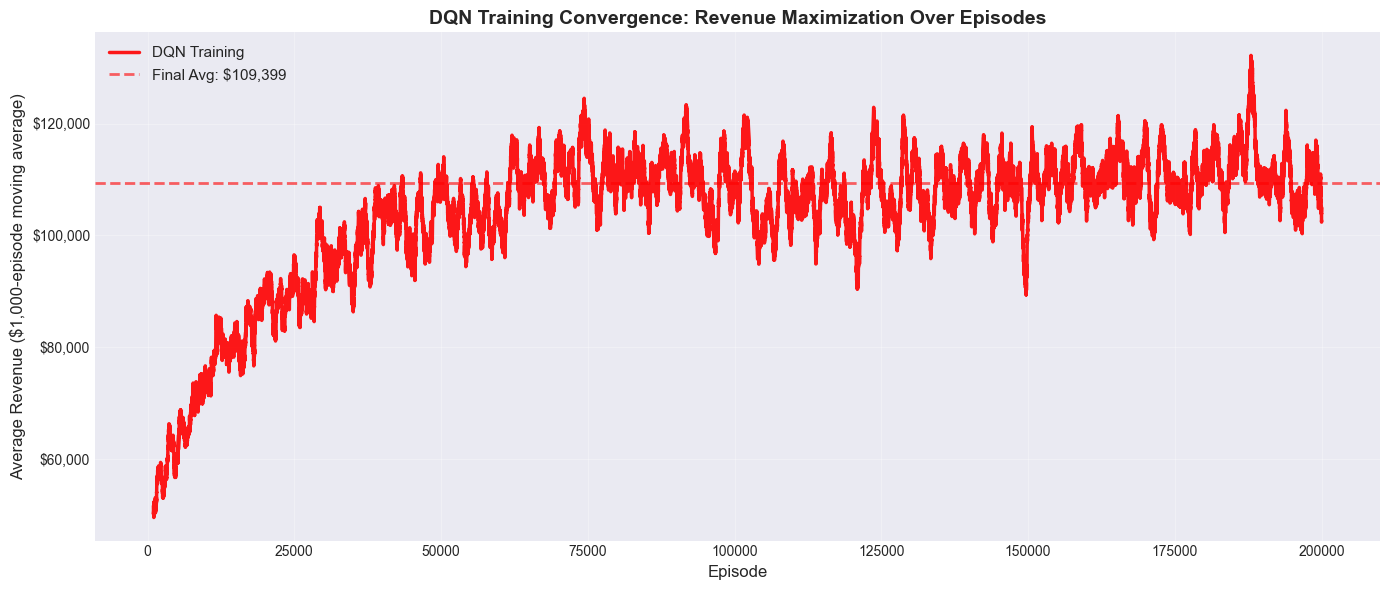


2/7: Total Revenue Comparison...
✓ Saved: total_revenue_comparison.png


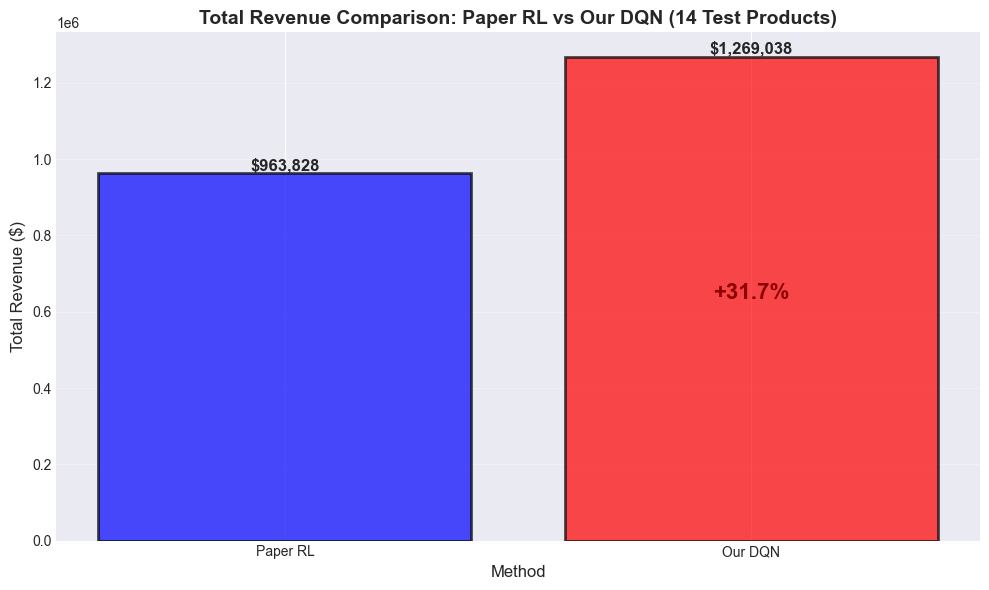


3/7: Product-wise Revenue Comparison...
✓ Saved: product_revenue_comparison.png


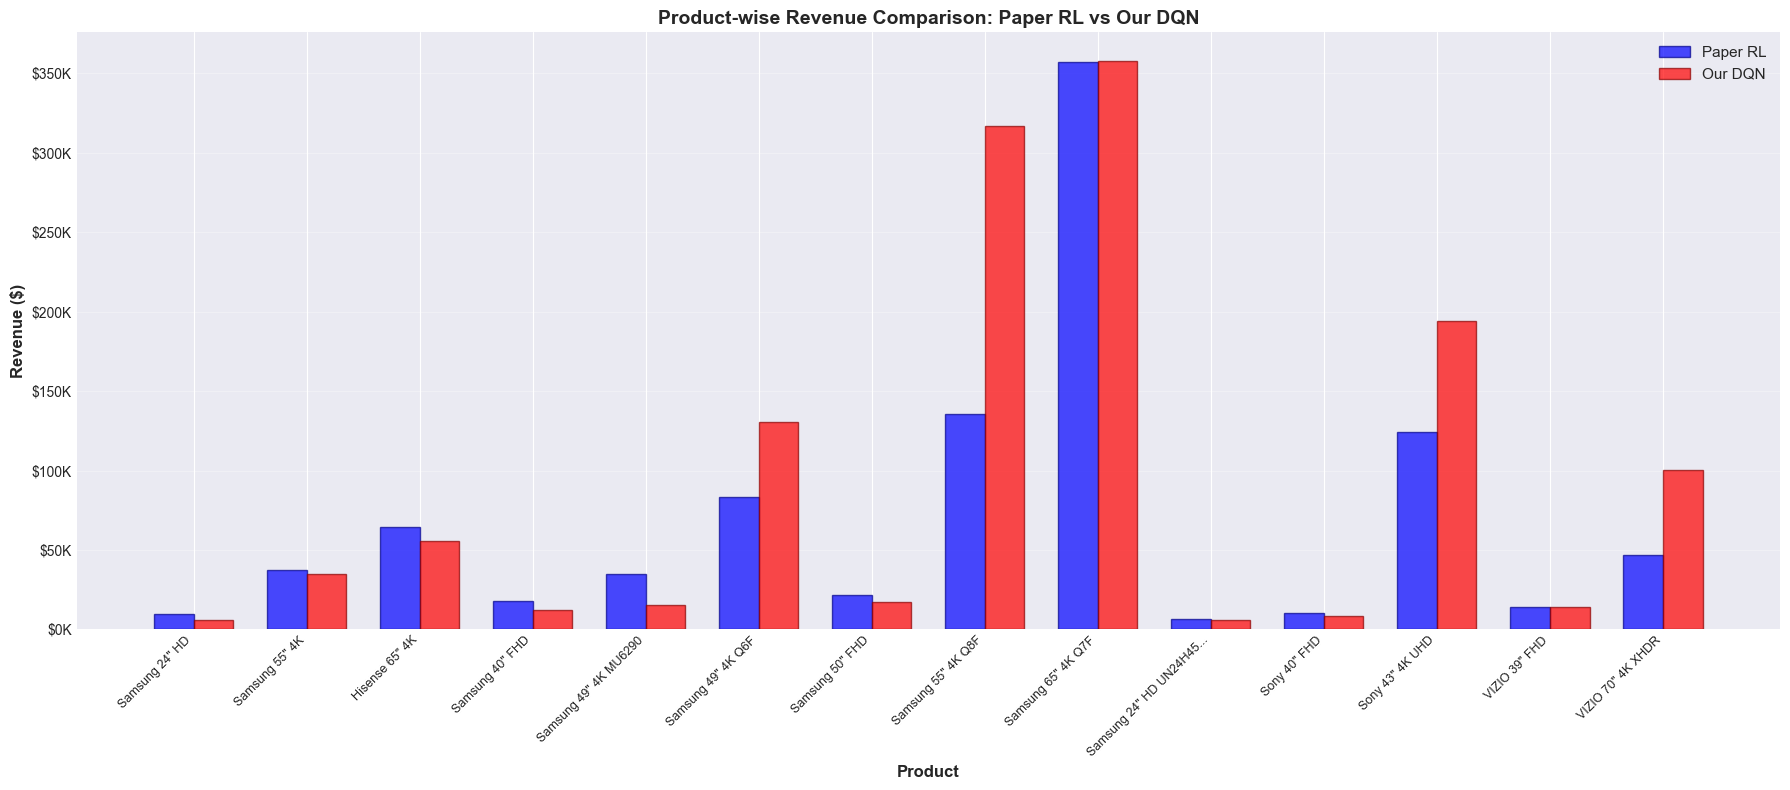


4/7: Revenue Improvement Heatmap...
✓ Saved: revenue_improvement_heatmap.png


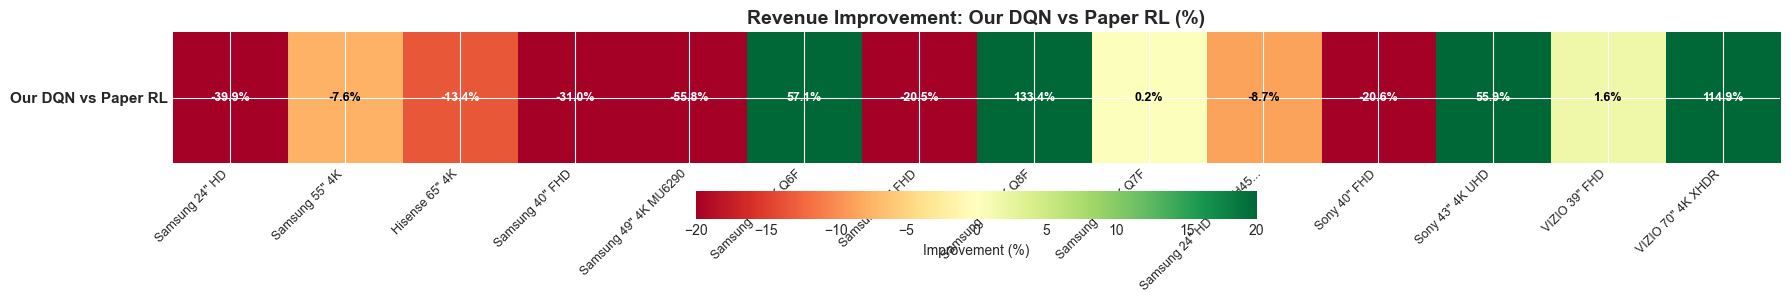


5/7: Cumulative Revenue...
✓ Saved: cumulative_revenue.png


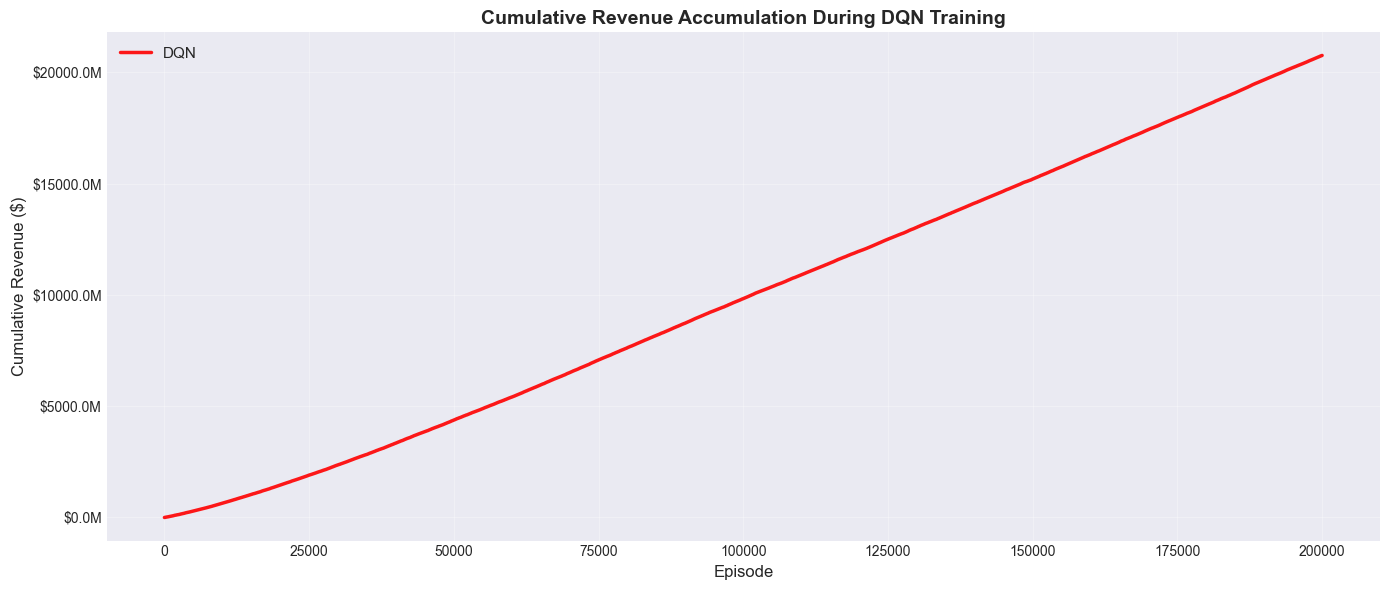


6/7: Demand vs Revenue Scatter...
✓ Saved: demand_revenue_scatter.png


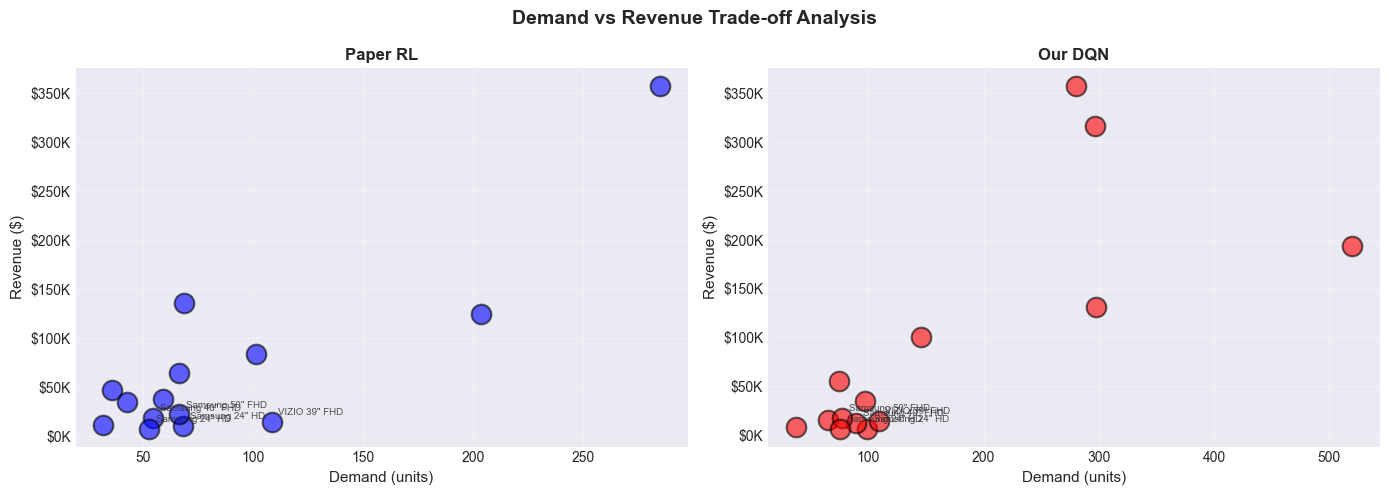


7/7: Summary Statistics...
✓ Saved: summary_statistics.png


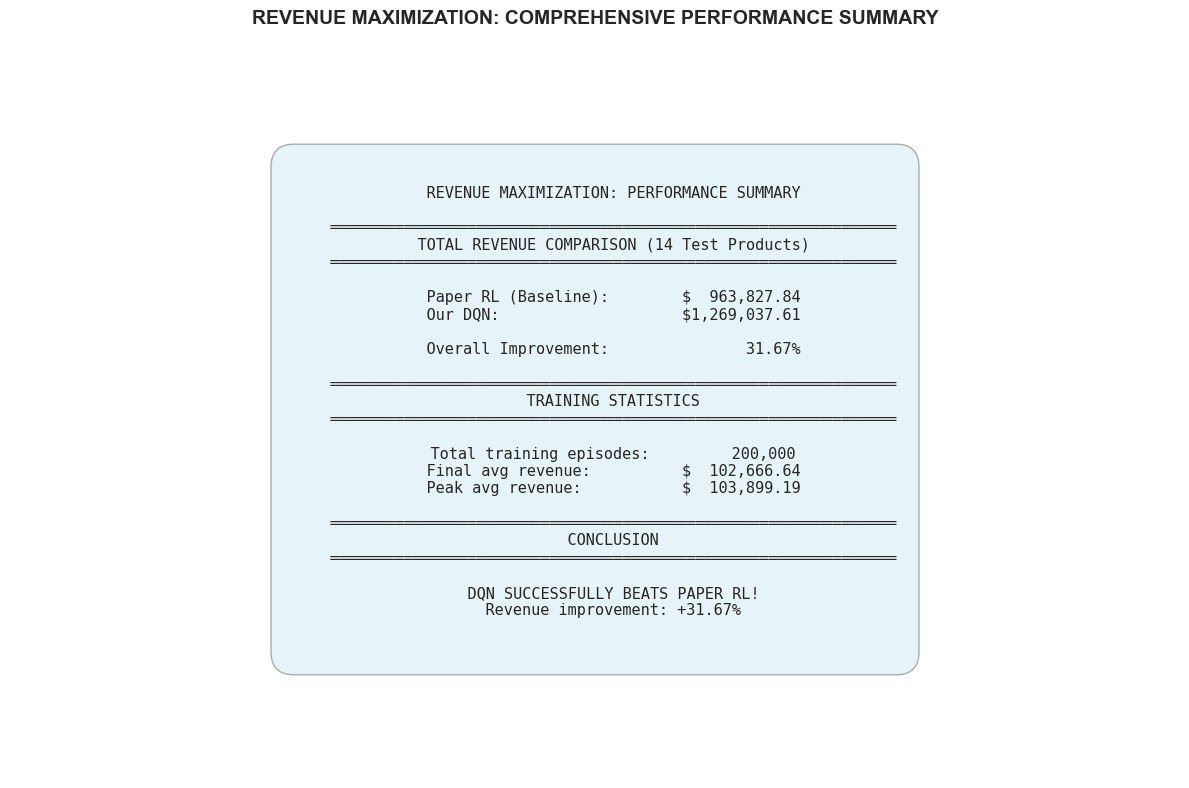

In [53]:
create_all_visualizations(agent, training_data, episode_rewards)